In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import operator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je ne baisse pas facilement les bras .', 'i m no quitter .']


In [8]:
pairs[419]

['nous sommes seules .', 'we re alone .']

### The above is the data preparation stage(for single batch). No code shall be changed. 

## 1. First test out with no batch size

### 1.1 Encoder with no batch

In [0]:
#Here for the constant definition
MAX_SENTENCE_LENGTH = 10
hidden_size = 256
SOS_token = 0
EOS_token = 1
max_length = 10


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1) # B x 1 x H
        #print('The embeddded size is {}'.format(embedded.size()))
        #When feeded in batch sizes, the size will be B x 1 x H, one token at a time
        output = embedded##Need changes if doing the batch size
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)

In [0]:
#For 1 batch size, prepare the test data
source_list = [pairs[i][0] for i in range(10)]
output_list = [pairs[i][1] for i in range(10)]

#Here they are strings:
input_tensor = source_list[0]
output_tensor = output_list[0]

#Transfer to tensor
input_tensor = tensorFromSentence(input_lang, input_tensor)
output_tensor = tensorFromSentence(output_lang, output_tensor)


In [0]:
encoder = EncoderRNN(input_lang.n_words, hidden_size)
if device == torch.device('cuda'):
    encoder.cuda()
else:
    encoder.cpu()

In [0]:
input_length = input_tensor.size(0)
output_length = output_tensor.size(0)

encoder_outputs = torch.zeros(MAX_SENTENCE_LENGTH, 
                              encoder.hidden_size, 
                              device = device)#10x256
encoder_hidden = encoder.initHidden()#1x1x256

#Encode the sentence one index at a time
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0,0]

### 1.2 Decoder with Attention
The decoder has already been batchified. Therefore 
if feeding 1 sentence at a time make sure unsqueeze the batch dimension

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers = 1, dropout_p = 0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size#vocab size of the output lang
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn1 = nn.Linear(hidden_size, hidden_size)
        self.attn2 = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, dropout = dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, word_input, last_hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        word_embedded = self.embedding(word_input).view(1,1,-1)
        word_embedded = self.dropout(word_embedded)

        #last hidden = B x 1 x 256
        #encoder outputs = B x 10 x 256

        #Scoring function
        last_hidden_repeated = last_hidden.repeat(1,encoder_outputs.size(1),1)
        attn_weights = F.tanh(torch.add(self.attn1(last_hidden_repeated),self.attn2(encoder_outputs)))
        v = self.v.unsqueeze(0).repeat(batch_size,1).unsqueeze(1)
        beta = v.bmm(attn_weights.transpose(1,2)) #batch x 1 x len
        alpha = F.softmax(beta.squeeze(1)).unsqueeze(1)#batch x 1 x len
        #End of scoring function
        
        context = alpha.bmm(encoder_outputs)#1 x 1 x 10 1 x 10 x 256 -> 1x 1 x 256
        rnn_input = torch.cat((word_embedded, context),2)#batch x 1 x 2hidden
        output, hidden = self.gru(rnn_input, last_hidden)#Hidden layer: layer x Bathc x Hidd

        output = output.squeeze(0)
        output = F.log_softmax(self.out(output))

        return output, hidden, alpha

# For single interations only, encoer_outputs already unsqueezed 

In [0]:
#encoder_outputs = encoder_outputs.unsqueeze(0)
encoder_outputs.size()

torch.Size([1, 10, 256])

In [0]:
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)
if device == torch.device('cuda'):
    attn_decoder.cuda()
else:
    attn_decoder.cpu()

/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
decoder_input = torch.tensor([[SOS_token]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [0]:
for di in range(output_length):
    decoder_output, decoder_hidden, decoder_attntion = attn_decoder(decoder_input, 
                                                     decoder_hidden, encoder_outputs)
    decoder_input = output_tensor[di]

/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Note: Encoder outputs remained unchanged -> can be used later for testing
## End of the decoder and encoder session
code shall not be changed. 
two sentence has already been encoded and now we
aim to generate best translation

## During the train, will be the inference state
## During training, no beam needed -> only during the evaluations state -> reference: Chow's note
two methods: greedy and beam search

# First greedy search: training and evaluations

In [0]:
#Greedy search
#DOnt execute these
#Training process:
teacher_forcing_ratio = 0.6
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #topv is the score, topi is the index of the highest score
        topv, topi = decoder_output.topk(1)

        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

NameError: name 'decoder' is not defined

In [0]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_token]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [0]:
#Evaluations:
decoded_words = []
decoder_attentions = torch.zeros(max_length, max_length)

for di in range(max_length):
    decoder_output, decoder_hidden, decoder_attention = attn_decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)#Take the best one
    #teacher forcing or not
    #decoder_input = topi.squeeze().detach()
    decoder_input = output_tensor[di]#For next round
    decoder_attentions[di] = decoder_attention[0,0]
    decoded_words.append(output_lang.index2word[topi.item()])#append the best token right now
    
    if decoder_input.item() == EOS_token:

        break;

/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
decoder_attentions

tensor([[0.5106, 0.1436, 0.0858, 0.0185, 0.0340, 0.0415, 0.0415, 0.0415, 0.0415,
         0.0415],
        [0.5122, 0.1391, 0.0874, 0.0178, 0.0318, 0.0423, 0.0423, 0.0423, 0.0423,
         0.0423],
        [0.4883, 0.1467, 0.0946, 0.0178, 0.0328, 0.0440, 0.0440, 0.0440, 0.0440,
         0.0440],
        [0.4913, 0.1440, 0.0894, 0.0180, 0.0327, 0.0449, 0.0449, 0.0449, 0.0449,
         0.0449],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<

# Second Beam Search: 

In [0]:
class SearchNode(object):
    def __init__(self, word_idx, hidden, curr_score, prev, curr_length):
        self.word_idx = word_idx#Tensor        
        self.hidden = hidden
        self.prev = prev
        if self.prev == None:
            self.score = curr_score
        else:
            self.score = self.prev.score + curr_score#The score summed up so far
        
        self.curr_length = curr_length #the nth node in the sentence
        #self.next = None
    


In [0]:
def init_beam(decoder_hidden, encoder_outputs, decoder, beam_width):
    decoder_input = torch.tensor([[SOS_token]], device = device)
    start_node = SearchNode(decoder_input,decoder_hidden, 0,None,1 )
    
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    curr_nodes = []
    scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
    for i in range(beam_width):
        curr_idx = indexes[0][i].view(1,-1)
            
        curr_score = scores[0][i].item()
        curr_node = SearchNode(curr_idx, decoder_hidden, curr_score, start_node, 2)
        curr_nodes.append((curr_node, curr_score))
        
    return curr_nodes, decoder_hidden

def beam_search(decoder_hidden,encoder_outputs,decoder,beam_width, k):
    '''
    beam_width: number of best nodes kept at each iterations
    k: number of sentences we want to keep
    '''
    curr_nodes, decoder_hidden = init_beam(decoder_hidden, encoder_outputs, decoder, beam_width)

    end_nodes = []#List including the ending nodes to trace back i.e. the EOS's
    #n_needed = min((k+1), k-len(end_nodes))
    
    while len(end_nodes) < k:
        candidate_nodes = []   
        for curr_node, curr_score in curr_nodes:
            
            #First we decide whether to terminate the search or not            
            if (curr_node.word_idx == EOS_token):#If already at the end of the sentence, then skip the calculation
                end_nodes.append((curr_node, curr_node.score))
                if len(end_nodes) >= k: #if already has the desired number of sentences generated
                    break;
                else:
                    continue;
                          
            #If the inference takes too long, also termiantes
            if curr_node.curr_length == 2000: #if too long will force to stop
                #Create an EOS dummy node to trace back the entire sentence
                
                EOS_node = SearchNode(torch.tensor([[EOS_token]], device = device), curr_node.hidden, 
                                      curr_node.score, curr_node, (curr_node.curr_length)+1)
                end_nodes.append((EOS_node, EOS_node.score))
                if len(end_nodes) >= k:
                    break;
                else:
                    continue;
            
            #If not, continue to inference the current time step choices, given the current node
            decoder_input = curr_node.word_idx
            decoder_hidden = curr_node.hidden
            decoder_output, decoder_hidden,decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Pick out k best for the current node
            scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
            for i in range(beam_width):
                candidate_idx = indexes[0][i].view(1,-1)
                candidate_score = scores[0][i].item()
                candidate_node = SearchNode(candidate_idx, decoder_hidden, candidate_score, curr_node, (curr_node.curr_length)+1)

                candidate_nodes.append((candidate_node, candidate_node.score))
        
        #Will now have candidate candidate_nodes with size beam_width * beam_width, only need the top beam_width one.
        curr_nodes = sorted(candidate_nodes, key = operator.itemgetter(1))
        curr_nodes = curr_nodes[:beam_width]

    return end_nodes              

In [0]:
#Translate the sentences.
def translate_end_nodes(end_nodes):
    sentences = []
    end_nodes = sorted(end_nodes, key = operator.itemgetter(1),reverse = True)
    for end_node, _ in end_nodes:
        sentence = []
        while end_node.prev != None:
            sentence.append(output_lang.index2word[end_node.word_idx.item()])
            end_node = end_node.prev
        sentence = sentence[::-1]#Reverse the sentence to get the sentence
        sentences.append(sentence)
    return sentences

# beam search test

In [0]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_token]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [0]:
#Test if the batch is unsqueezed; only doing so when batch not implemented and hidden size = 256 max_length = 10
list(encoder_outputs.size()) == [1, 10, 256]

True

In [0]:
end_nodes = beam_search(decoder_hidden, encoder_outputs, decoder = attn_decoder, beam_width = 10, k = 1)

/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
end_nodes

[(<__main__.SearchNode at 0x122323b00>, -10116.319769859314)]

In [0]:
result = translate_end_nodes(end_nodes)
print(len(result[0]))
result[0][:20]

1340


['immediately',
 'television',
 'those',
 'endowed',
 'chances',
 'foggy',
 'actress',
 'grateful',
 'discussing',
 'eggs',
 'about',
 'caught',
 'look',
 'familiar',
 'typist',
 'nice',
 'power',
 'cousin',
 'choices',
 'hook']

# End of testing beam search

In [0]:
#Evaluations: beam_width = 2
end_nodes = beam_search(decoder_hidden, encoder_outputs,decoder = attn_decoder, k=2)


/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


AttributeError: 'tuple' object has no attribute 'word_idx'

Train the lab data, if workable, then implement the mini-batch

## Train function works#

In [0]:
encoder_hidden = encoder1.initHidden()

In [0]:
input_length = input_tensor.size(0)
output_length = output_tensor.size(0)

In [0]:
encoder_outputs = torch.zeros(max_length, encoder1.hidden_size, device=device)

In [0]:
encoder_output, encoder_hidden = encoder1(input_tensor[0], encoder_hidden)

In [0]:
for ei in range(input_length):
        encoder_output, encoder_hidden = encoder1(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

## End of train function

In [0]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 10
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    #Added specifically for this test
    encoder_outputs = encoder_outputs.unsqueeze(0)
    #Will be deleted
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=1, dropout_p=0.1).to(device)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


4m 50s (- 67m 45s) (5000 6%) 2.8977
9m 38s (- 62m 41s) (10000 13%) 2.2920
14m 26s (- 57m 44s) (15000 20%) 1.9737
19m 17s (- 53m 3s) (20000 26%) 1.7344
24m 9s (- 48m 18s) (25000 33%) 1.5166
29m 1s (- 43m 31s) (30000 40%) 1.3491
33m 52s (- 38m 42s) (35000 46%) 1.2389
38m 46s (- 33m 55s) (40000 53%) 1.0919
43m 39s (- 29m 6s) (45000 60%) 0.9597
48m 33s (- 24m 16s) (50000 66%) 0.8673
53m 29s (- 19m 27s) (55000 73%) 0.7623
58m 23s (- 14m 35s) (60000 80%) 0.7051
63m 17s (- 9m 44s) (65000 86%) 0.6131
68m 11s (- 4m 52s) (70000 93%) 0.5485
73m 5s (- 0m 0s) (75000 100%) 0.5004


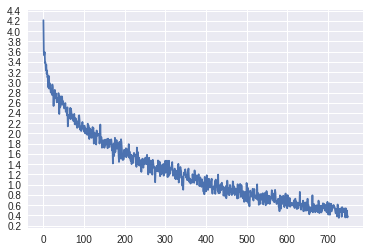

In [16]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [0]:
training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(75000)]

In [0]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=0.01)

In [0]:
criterion = nn.NLLLoss()


In [0]:
loss = train(input_tensor, output_tensor, encoder1,
                     attn_decoder1, encoder_optimizer, decoder_optimizer, criterion)

/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
